In [1]:
from google.colab import drive  #Para enlazar a Drive
import pandas as pd             #Para manejar la base de datos
import glob, os                 #Para leer archivos de drive
import datetime                 #Para manejar fechas
import numpy as np
import time
import re

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = 'drive/MyDrive/IPC Bienes/Consolidados/TV/Scrapers/'

In [28]:
db = {}
i=1
for filename in glob.glob(os.path.join(path, '*.csv')):
  db[i] = pd.read_csv(filename)
df = pd.concat(db.values())

In [29]:
df = df.loc[df['Tienda'].isin(['Falabella', 'Ripley', 'Paris'])]

In [30]:
df = df[~df.Modelo.str.contains(" \+")]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5255 entries, 1 to 15283
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Marca           5255 non-null   object
 1   Modelo          5255 non-null   object
 2   Tienda          5255 non-null   object
 3   Precio_Tarjeta  5255 non-null   object
 4   Precio Normal   5255 non-null   int64 
 5   LED             5255 non-null   object
 6   Pulgadas        5255 non-null   object
 7   Resolucion      5255 non-null   object
 8   SmartTV         5255 non-null   object
 9   Tasa_Refresco   5255 non-null   object
 10  Puertos USB     5255 non-null   object
 11  Tipo Panel      5255 non-null   object
 12  Parlantes       5255 non-null   object
 13  Fecha           5255 non-null   object
dtypes: int64(1), object(13)
memory usage: 615.8+ KB


Agrupación de tasas de refresco en categorías ```60hz``` y ```+60hz```:

In [32]:
df.loc[df['Tasa_Refresco']=="60 Hz", '60hz'] = 1
df.loc[~(df['Tasa_Refresco']=="60 Hz"), '+60hz'] = 1

df.fillna({'60hz':0,'+60hz':0}, inplace=True)

df.drop('Tasa_Refresco', axis=1, inplace=True)

Agrupación de tasas de refresco en categorías ```HD```, ```FullHD``` y ```+4K```:

In [33]:
df['Resolucion'].unique()

array(['HD (1366x768)', 'Full HD (1920x1080)', '4k Ultra HD (3840x2160)',
       '8K Full Ultra HD (7680x4320)', 'HD 720p (1280x720)'], dtype=object)

In [34]:
df['Resolucion'] = df['Resolucion'].replace({'HD (1366x768)':'HD',
                                             'HD 720p (1280x720)':'HD',
                                             'Full HD (1920x1080)':'FulHD',
                                             '4k Ultra HD (3840x2160)':'4K',
                                             '8K Full Ultra HD (7680x4320)':'8K'})

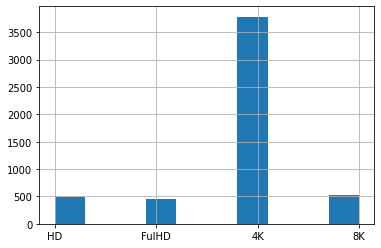

In [35]:
df['Resolucion'].hist()

In [36]:
df.loc[(df['Resolucion']=="HD")|(df['Resolucion']=='FullHd'), 'HD'] = 1
df.loc[(df['Resolucion']=="4K"), '4K'] = 1
df.loc[(df['Resolucion']=="8K"), '8K'] = 1

df[['HD', '4K', '8K']] = df[['HD','4K', '8K']].fillna(value=0)

df.drop('Resolucion', axis=1, inplace=True)

In [63]:
df['Pulgadas'] = df['Pulgadas'].replace('[\.0"]','',regex=True).replace('[\,0"]','',regex=True).astype(int)

In [64]:
df

,Marca,Modelo,Tienda,Precio_Tarjeta,Precio Normal,LED,Pulgadas,SmartTV,Puertos USB,Tipo Panel,Parlantes,Fecha,60hz,+60hz,HD,4K,8K
1,BGH,B2418K4IC,Paris,$ 139.990,139990,LED,24,No,1,TN,2x 5 W,2021-04-03,1.0,0.0,1.0,0.0,0.0
2,Haier,H32K6G,Ripley,$ 149.990,169990,LED,32,Sí,2,TN,2x 5 W,2021-04-03,1.0,0.0,1.0,0.0,0.0
7,Recco,RLED-L32D2000A,Falabella,$ 149.990,149990,LED,32,Sí,2,TN,2x 5 W,2021-04-03,1.0,0.0,0.0,0.0,0.0
10,Winia,Daewoo L32V750BAS,Falabella,$ 179.990,179990,LED,32,Sí,2,TN,2x 7 W,2021-04-03,1.0,0.0,1.0,0.0,0.0
14,Caixun,CS43S1USM,Ripley,$ 189.990,209990,LED,43,Sí,2,TN,2x 10 W,2021-04-03,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15276,Samsung,QN85Q950TS,Falabella,$ 5.499.990,5499990,QLED,85,Sí,3,VA,2x 35 W,2021-04-30,0.0,1.0,0.0,0.0,1.0
15278,Samsung,QN85Q950TS,Ripley,$ 5.799.990,5799990,QLED,85,Sí,3,VA,2x 35 W,2021-04-30,0.0,1.0,0.0,0.0,1.0
15279,Samsung,QN85Q950TS,Paris,$ 5.899.990,5899990,QLED,85,Sí,3,VA,2x 35 W,2021-04-30,0.0,1.0,0.0,0.0,1.0
15282,Sony,XBR-85Z8H,Ripley,$ 4.999.990,4999990,LED,85,Sí,3,TN,2x 30 W,2021-04-30,1.0,0.0,0.0,0.0,1.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5255 entries, 1 to 15283
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Marca           5255 non-null   object 
 1   Modelo          5255 non-null   object 
 2   Tienda          5255 non-null   object 
 3   Precio_Tarjeta  5255 non-null   object 
 4   Precio Normal   5255 non-null   int64  
 5   LED             5255 non-null   object 
 6   Pulgadas        5255 non-null   int64  
 7   SmartTV         5255 non-null   object 
 8   Puertos USB     5255 non-null   object 
 9   Tipo Panel      5255 non-null   object 
 10  Parlantes       5255 non-null   object 
 11  Fecha           5255 non-null   object 
 12  60hz            5255 non-null   float64
 13  +60hz           5255 non-null   float64
 14  HD              5255 non-null   float64
 15  4K              5255 non-null   float64
 16  8K              5255 non-null   float64
dtypes: float64(5), int64(2), object(

Modelo atemporal:

In [66]:
df2 = df.drop(['Marca', 'Modelo', 'Tienda', 'Precio_Tarjeta', 'Fecha', 'Parlantes'], axis=1)

In [67]:
df2_mco = pd.get_dummies(df2, )

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
x = df2_mco.loc[:, df2_mco.columns != 'Precio Nomal']
y = df2_mco['Precio Normal']

In [51]:
def MCO(X_train, X_test, y_train, y_test):
  # Create linear regression object
  regr = LinearRegression()

  # Train the model using the training sets
  regr.fit(X_train, y_train)

  # Make predictions using the testing set
  y_pred = regr.predict(X_test)

  # The root mean squared error
  rmse = (mean_squared_error(y_test, y_pred))**0.5

  # The coefficient of determination: 1 is perfect prediction
  r2 = r2_score(y_test, y_pred)

  # Return Model, Intercept, Cefficients, RMSE, R^2
  Data = ['MCO' , regr.intercept_ ] + list(regr.coef_) + [rmse, r2]
  return(Data)

In [77]:
df2_mco.to_csv(path+'DF2.csv', index_label=False)

In [74]:
df2_mco.iloc[:,1:23]

,Pulgadas,60hz,+60hz,HD,4K,8K,LED_LCD,LED_LED,LED_NanoCell,LED_OLED,LED_QLED,SmartTV_No,SmartTV_Sí,Puertos USB_1,Puertos USB_2,Puertos USB_3,Puertos USB_No posee,Tipo Panel_IPS,Tipo Panel_OLED,Tipo Panel_TN,Tipo Panel_VA
1,24,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
2,32,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
7,32,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
10,32,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
14,43,1.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15276,85,0.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
15278,85,0.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
15279,85,0.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
15282,85,1.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0


In [73]:
from statsmodels.formula.api  import ols
#you need a Pandas dataframe df with columns labeled Y, X, & X2
all_columns = "+".join(df2_mco.columns.difference(["Precio Normal"]))

est = ols(formula = 'df2_mco.iloc[:,0] ~ df2_mco.iloc[:,1:23]', data = df2_mco).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     df2_mco.iloc[:, 0]   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     780.0
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        13:56:10   Log-Likelihood:                -76672.
No. Observations:                5255   AIC:                         1.534e+05
Df Residuals:                    5238   BIC:                         1.535e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.394e+05   2.28e+04      6.123      0.000    9.48e+04    1.84e+05
df2_mco.iloc[:, 1:23][0]   7646.7485    354.582     21.566      0.000    6951.619    8341.878
df2_mco.iloc[:, 1:23][1]  -6.176e+04   1.49e+04     -4.151      0.000   -9.09e+04   -3.26e+04
df2_mco.iloc[:, 1:23][2]   2.012e+05   1.58e+04     12.694      0.000     1.7e+05    2.32e+05
df2_mco.iloc[:, 1:23][3]  -2.695e+04   3.52e+04     -0.765      0.444    -9.6e+04    4.21e+04
df2_mco.iloc[:, 1:23][4]   1.196e+05   2.71e+04      4.420      0.000    6.66e+04    1.73e+05
df2_mco.iloc[:, 1:23][5]   1.698e+06   4.05e+04     41.897      0.000    1.62e+06    1.78e+06
df2_mco.iloc[:, 1:23][6]   8.487e+04    7.9e+04      1.074      0.283      -7e+04     2.4e+05
df2_mco.iloc[:, 1:23][7]  -1.168e+05   5.21e+04     -2.240      0.025   -2.19e+05   -1.46e+04
df2_mco.iloc[:, 1:23][8]  -4.247e+05   6.28e+04     -6.761      0.000   -5.48e+05   -3.02e+05
df2_mco.iloc[:, 1:23][9]   6.588e+05   1.89e+05      3.478      0.001    2.87e+05    1.03e+06
df2_mco.iloc[:, 1:23][10] -6.275e+04    5.4e+04     -1.163      0.245   -1.69e+05     4.3e+04
df2_mco.iloc[:, 1:23][11]  8.156e+04   5.12e+04      1.592      0.112   -1.89e+04    1.82e+05
df2_mco.iloc[:, 1:23][12]  5.787e+04   3.56e+04      1.624      0.104    -1.2e+04    1.28e+05
df2_mco.iloc[:, 1:23][13] -1.602e+05   2.59e+04     -6.186      0.000   -2.11e+05   -1.09e+05
df2_mco.iloc[:, 1:23][14] -4.145e+04   2.25e+04     -1.839      0.066   -8.56e+04    2733.808
df2_mco.iloc[:, 1:23][15]   5.52e+05   3.04e+04     18.162      0.000    4.92e+05    6.12e+05
df2_mco.iloc[:, 1:23][16] -2.108e+05   6.66e+04     -3.163      0.002   -3.41e+05   -8.02e+04
df2_mco.iloc[:, 1:23][17] -7.927e+04   6.22e+04     -1.274      0.203   -2.01e+05    4.27e+04
df2_mco.iloc[:, 1:23][18]  5024.3890    1.8e+05      0.028      0.978   -3.48e+05    3.58e+05
df2_mco.iloc[:, 1:23][19]  3.709e+04   5.97e+04      0.621      0.534      -8e+04    1.54e+05
df2_mco.iloc[:, 1:23][20]  1.766e+05   6.06e+04      2.915      0.004    5.78e+04    2.95e+05
==============================================================================
Omnibus:                     2469.801   Durbin-Watson:                   0.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25915.764
Skew:                           1.981   Prob(JB):                         0.00
Kurtosis:                      13.132   Cond. No.                     2.09e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.45e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [60]:
all_columns

'+60hz+4K+60hz+8K+HD+LED_LCD+LED_LED+LED_NanoCell+LED_OLED+LED_QLED+Puertos USB_1+Puertos USB_2+Puertos USB_3+Puertos USB_No posee+Pulgadas_22.0"+Pulgadas_24.0"+Pulgadas_32.0"+Pulgadas_39.0"+Pulgadas_40.0"+Pulgadas_43.0"+Pulgadas_49.0"+Pulgadas_50.0"+Pulgadas_55.0"+Pulgadas_58.0"+Pulgadas_60.0"+Pulgadas_65.0"+Pulgadas_70.0"+Pulgadas_75.0"+Pulgadas_77.0"+Pulgadas_82,0"+Pulgadas_85.0"+Pulgadas_86,0"+SmartTV_No+SmartTV_Sí+Tipo Panel_IPS+Tipo Panel_OLED+Tipo Panel_TN+Tipo Panel_VA'